In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def one_hot_encoding_1D(sequences):
    """Perform one hot encoding on DNA sequences.
    sequences is a list of DNA sequences.
    Returns a numpy array of the shape (number_of_sequences, max_len, 4).
    This is compatible as input for 1D CNN."""
    from keras.preprocessing.text import Tokenizer
    from keras.utils import to_categorical
    tokenizer = Tokenizer(char_level=True)
    tokenizer.fit_on_texts(['ACGT'])
    sequence_of_int = tokenizer.texts_to_sequences(sequences)
    one_hot_encoded = to_categorical(sequence_of_int)
    one_hot_encoded = one_hot_encoded[..., 1:]
    one_hot_reshaped = one_hot_encoded.reshape((len(sequences), 250, 4))
    return one_hot_reshaped

import sys
import os

def expression_model(params):
    from keras import layers
    from keras import models
    from keras.optimizers import Adam
    from keras.regularizers import l1_l2
    num_filters = params['num_filters']
    num_filters2 = params['num_filters2']
    kernel_size = params['kernel_size']
    kernel_size2 = params['kernel_size2']
    l1_lambda = params['l1_lambda']
    l2_lambda = params['l2_lambda']
    lr = params['lr']
    model = models.Sequential()
    model.add(layers.Conv1D(num_filters, kernel_size, input_shape=(250, 4), activation='relu',
                            kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda), name='1st_Conv1D'))
    model.add(layers.MaxPooling1D(2, strides=1, name='1st_MaxPooling1D'))
    model.add(layers.Dropout(0.5, name='1st_Dropout'))
    model.add(layers.Conv1D(num_filters2, kernel_size2, activation='relu',
                            kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda), name='2nd_Conv1D'))
    model.add(layers.MaxPooling1D(2, strides=1, name='2nd_MaxPooling1D'))
    model.add(layers.Dropout(0.5, name='2nd_Dropout'))
    model.add(layers.Flatten(name='Flatten'))
    model.add(layers.Dense(1, kernel_regularizer=l1_l2(l1=l1_lambda, l2=l2_lambda), name='Output'))
    model.compile(Adam(lr=lr), 'mse')
    return model


In [2]:
#Load dataframe of sequences to predict APA for

df = pd.read_csv('leslie_derti_apadb_features_pas_3_utr3.csv', sep='\t')


In [3]:
#Score all sequences with APARENT (use sum of cuts to capture OR-like logic)

params = {
    'batch_size': 256,
    'epochs': 75,
    'kernel_size': 8,
    'kernel_size2': 6,
    'l1_lambda': 0.0001,
    'l2_lambda': 0.0001,
    'lr': 0.0015,
    'num_filters': 64,
    'num_filters2': 32
}

model = expression_model(params)
model.load_weights('SavedModels/saved_cnn_expression_model.h5')

max_n_pas = 10

a = np.zeros((len(df), max_n_pas))
m = np.zeros((len(df), max_n_pas))

for k in range(max_n_pas) :
    
    print("Predicting for PAS #" + str(k) + "...")
    
    m[:, k] = np.array(~df['wide_seq_ext_' + str(k)].isnull(), dtype=np.int)
    
    df.loc[df['wide_seq_ext_' + str(k)].isnull(), 'wide_seq_ext_' + str(k)] = 'A' * 356
    
    df['seeq_' + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(175-70-30-25, 175-70+205+15-25)
    
    one_hots = one_hot_encoding_1D([row['seeq_' + str(k)] for _, row in df.iterrows()])
    
    a[:, k] = model.predict(x=[one_hots], batch_size=32, verbose=1)[:, 0]

a = m * a
a = np.clip(a, -8., 8.)


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Predicting for PAS #0...
6944/6944 [==============================] - 2s 238us/step
Predicting for PAS #1...
6944/6944 [==============================] - 0s 67us/step
Predicting for PAS #2...
6944/6944 [==============================] - 0s 68us/step
Predicting for PAS #3...
6944/6944 [==============================] - 0s 68us/step
Predicting for PAS #4...
6944/6944 [==============================] - 0s 68us/step
Predicting for PAS #5...
6944/6944 [==============================] - 0s 68us/step
Predicting for PAS #6...
6944/6944 [==============================] - 0s 68us/step
Predicting for PAS #7...
6944/6944 [==============================] - 0s 67us/step
Predicting for PAS #8...
6944/6944 [==============================] - 0s 68us/step
Predicting for PAS #9...
6944/6944 [=============================

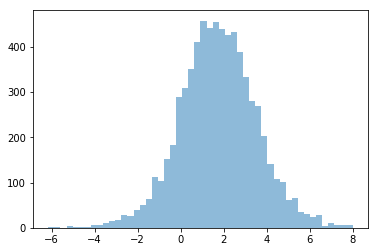

In [4]:
import matplotlib.pyplot as plt

f = plt.figure()

plt.hist(a[:, 0], bins=50, alpha=0.5)

plt.show()


In [5]:
#Store predictions

np.save('leslie_derti_apadb_features_pas_3_utr3_polyapred_native_scores_shifted', a)
